In [1]:
import numpy as np
import pandas as pd
from csv import writer
import json
import time
import glob
import os
from pathlib import Path
import sys

In [2]:
import sys, os, random, csv
from nltk import sent_tokenize
from nltk.tokenize import TweetTokenizer

NEED_TERMS = set(['need', 'needs', 'needed', 'needing', 'require', 'requires', 'requiring', 'want', 'wants', 'wanting' ])

def myfunc(first, second, third) :
    if __name__=="__main__":

        INPUT_FILE = first
        OUTPUT_FILE = os.path.join("NewGSData", second)
        NUM_SENTS =  int(third)

        tokenizer = TweetTokenizer()

        need_sents = []
        with open(INPUT_FILE, 'r', encoding="utf-8") as f:
            with open(OUTPUT_FILE, 'w', encoding="utf-8") as o:
                for line in f:
                    sentences = sent_tokenize(line)
                    for raw_sent in sentences:
                        raw_tokens = tokenizer.tokenize(raw_sent)

                        if len(NEED_TERMS.intersection(raw_tokens)) > 0:
                            need_sents.append(raw_sent)
        
        sample = random.choices(need_sents, k = NUM_SENTS)
        with open(OUTPUT_FILE, 'w', encoding="utf-8") as o:
            writer = csv.writer(o)
            writer.writerow(['id', 'text'])
            for id_, sentence in enumerate(sample):
                writer.writerow([id_, sentence])

In [135]:
# os.makedirs("D:/test")

In [3]:
import os, sys, json, time, ahocorasick
from gensim.models import Word2Vec
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from collections import defaultdict


# read phrases file
def priority(first, second, third):

    NEED_TERMS = ['needs']

    
    def read_phrases(PHRASES_FILE):
        # ahocorasick: faster way of searching for phrases in text
        phrase_search = {}
        for i in range(MIN_PHRASE_LENGTH, MAX_PHRASE_LENGTH + 1):
            phrase_search[i] = ahocorasick.Automaton()

        all_phrases = []
        with open(PHRASES_FILE, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip().split('\t')
                if len(line) > 1 and float(line[0]) >= PHRASE_THRESHOLD:
                    if line[1].endswith("'s"):
                        line[1] = line[1][:-2]
                    
                    tokens = tokenizer.tokenize(line[1])
                    if len(tokens) <= MAX_PHRASE_LENGTH and len(tokens) >= MIN_PHRASE_LENGTH:
                        phrase = '-'.join(tokens)

                        phrase_search[len(tokens)].add_word(line[1], (line[1], phrase))

                        all_phrases.append(phrase)

        for i in range(MIN_PHRASE_LENGTH, MAX_PHRASE_LENGTH + 1):
            phrase_search[i].make_automaton()
                        
        return all_phrases, phrase_search

    # annotate phrases in text so they are kept as unigrams
    def annotate_phrases(raw_sent, phrases):
        phrase_sent = raw_sent.lower()
        for i in range(MAX_PHRASE_LENGTH , MIN_PHRASE_LENGTH - 1, -1):
            if len(phrases[i]) > 0:
                phrases_in_sent = {}
                for end_index, (phrase, combined_phrase) in phrases[i].iter(phrase_sent):
                    phrases_in_sent[phrase] = combined_phrase

                for phrase in sorted(phrases_in_sent, key = len, reverse = True):
                    phrase_sent = phrase_sent.replace(phrase, phrases_in_sent[phrase])

        return phrase_sent

    def get_nouns(vocab_pos, phrases):
        nouns = set()
        for word, tags in vocab_pos.items():
            # if word == 'needed':
            #     print(tags)
            # if word is more frequently used as a noun, add it to list of nouns
            if max(tags, key = tags.get) in ['NN', 'NNS', 'NNP', 'NNPS']:
                nouns.add(word)
                # nouns.append(word)

        for phrase in phrases:
            tokens = phrase.split('-')
            final_token = tokens[-1]

            if final_token in nouns:
                nouns.add(phrase)
                # nouns.append(word)

        return nouns

    # find all nouns closest to NEED_TERMS
    def get_ranked_needs(emb_model, nouns, output_file, top = 100):
        top_noun_count = 0
        with open(os.path.join(output_file), 'w', encoding='utf-8') as o:
            for (term, score) in emb_model.wv.most_similar(positive = NEED_TERMS, topn = top * 2):
                if term in nouns:
                    top_noun_count += 1
                    o.write(term + '\n')

                    if top_noun_count == top:
                        break

    if __name__=="__main__":
        start_time = time.time()

        INPUT_FILE = first
        OUTPUT_FOLDER = second
        OUTPUT_FILE = os.path.join(OUTPUT_FOLDER, 'sentences.json')
        NEEDS_FILE = os.path.join(OUTPUT_FOLDER, 'priority-needs.txt')

        PHRASES_FILE = third
        PHRASE_THRESHOLD = 0.8
        MIN_PHRASE_LENGTH = 2
        MAX_PHRASE_LENGTH = 5

        # if len(sys.argv) < 5:
        TOPN = 100

        tokenizer = TweetTokenizer()

        all_phrases, phrase_search = read_phrases(PHRASES_FILE)

        print('Initialization took {} seconds'.format((time.time() - start_time)))

        # read tweets and split into sentences and tokens
        print('Performing phrase annotation and POS tagging...')
        tagging_start_time = time.time()

        all_sents = []
        vocab_pos = {}
        # row = 0
        with open(INPUT_FILE, 'r', encoding='utf-8') as f:
            with open(OUTPUT_FILE, 'w', encoding='utf-8') as o:
                for line in f:
                    sentences = sent_tokenize(line)
                    for raw_sent in sentences:
                        raw_tokens = tokenizer.tokenize(raw_sent)

                        phrase_sent = annotate_phrases(raw_sent, phrase_search)
                        phrase_tokens = tokenizer.tokenize(phrase_sent)

                        pos = pos_tag(raw_tokens)
                        
                        json.dump({
                            'raw_sent' : raw_sent,
                            'raw_tokens' : raw_tokens,
                            'phrase_sent' : phrase_sent,
                            'phrase_tokens' : phrase_tokens,
                            'pos' : pos
                            }, o)
                        o.write('\n')

                        all_sents.append(phrase_tokens)

                        for (word, tag) in pos:
                            if word not in vocab_pos:
                                vocab_pos[word.lower()] = defaultdict(int)
                            vocab_pos[word.lower()][tag] += 1 

                    # row = row + 1
                    # if row == 2000: break

        nouns = get_nouns(vocab_pos, all_phrases)

        print('Tagging took {} seconds'.format((time.time() - tagging_start_time)))

        # generate word embeddings
        print('Generating word embeddings...')
        embedding_start_time = time.time()

        model = Word2Vec(sentences = all_sents)
        model.save(os.path.join(OUTPUT_FOLDER, 'word2vec.model'))
        print('Embedding took {} seconds'.format((time.time() - embedding_start_time)))

        print('Identifying needs and priorities...')
        detection_start_time = time.time()

        get_ranked_needs(model, nouns, NEEDS_FILE, TOPN)
        
        print('Needs detection took {} seconds'.format((time.time() - detection_start_time)))

        print('END: whole process took {} seconds'.format((time.time() - start_time)))

In [137]:

p = str(Path.cwd()) + "/ukraine_tweets"
files = glob.glob(os.path.join(p,"*.npy"))

for f in files:
    print(os.path.basename(f).split('/')[0])
    
    dataset = np.load(f, allow_pickle=True).tolist()
    df = pd.DataFrame(dataset)
    df = df[df["lang"] == "en"]
    # Tokenizing/Cleaning?
    df[["full_text"]].to_csv('outp.csv',encoding='utf-8', index=False, errors="replace")

    gsnd = os.path.basename(f).split('/')[-1][0:10] 
    print(gsnd + " Loading Dataset")
    # think about number pulled
    # print(str(int(len(df)*.1)))

    myfunc("outp.csv", "GS" + gsnd,str(int(len(df)*.2)) )


    # # dir = os.path.join(str(Path.cwd()) +  )
    prio = "NewWordData/" + "WORDS" + gsnd
    if not os.path.exists(prio): 
        os.makedirs(prio)
    else:
        print("Skipped")
        continue
    # priority("outp.csv", prio, "gsData\GS" + gsnd)
    # think about this
    priority("NewGSData\GS" + gsnd, prio, "NewGSData\GS" + gsnd)
    
    # clear_output(wait=True)

    # Take generated noun files and concact, removing dupicates
    # loop though again to parse for nouns for each day, collect tweets and date
    # for each noun to then get frequencies and dates, relate that to 
    # occurance of each need and adjust for each day's number
    # of tweets for averages

2022-09-17.npy
2022-09-17 Loading Dataset
Initialization took 0.016637563705444336 seconds
Performing phrase annotation and POS tagging...
Tagging took 9.18942379951477 seconds
Generating word embeddings...
Embedding took 0.3230016231536865 seconds
Identifying needs and priorities...
Needs detection took 0.014997005462646484 seconds
END: whole process took 9.546066522598267 seconds
2022-09-05.npy
2022-09-05 Loading Dataset
Initialization took 0.01201939582824707 seconds
Performing phrase annotation and POS tagging...
Tagging took 7.84005880355835 seconds
Generating word embeddings...
Embedding took 0.25922393798828125 seconds
Identifying needs and priorities...
Needs detection took 0.005003929138183594 seconds
END: whole process took 8.116306066513062 seconds
2022-09-13.npy
2022-09-13 Loading Dataset
Initialization took 0.014004707336425781 seconds
Performing phrase annotation and POS tagging...
Tagging took 10.397747039794922 seconds
Generating word embeddings...
Embedding took 0.3138

In [52]:
frames = []

df2 = pd.read_csv("NewGSData\GS2022-05-10")
df2 = df2.drop_duplicates(subset="text")
# count = df2["text"].str.contains("needs", case = False)
# df2["need"] = count
df2

# count = df2["text"].str.contains("needs", case = False).sum()


# frames.append(df2)

# df3 = pd.read_csv("NewGSData\GS2022-02-23")
# df3 = df3.drop_duplicates(subset="text")
# df3

# frames.append(df3)

# df4 = pd.concat(frames, ignore_index=True)
# df4.to_csv("blah.csv",encoding='utf-8', index=False)
# df4

,id,text
0,0,Here’s a thread on what you need to know about...
1,1,"""RT @RepMTG: I want to remind Congress we swor..."
2,2,RT @GuntherEagleman: Zelensky doesn't need any...
3,3,We have people wanting their cut.
4,4,Message from France: Russia needs to be integr...
...,...,...
5133,5133,@200_zoka @GeromanAT I want to say that Russia...
5156,5156,"He needs to go."""""
5223,5223,@Maytechummia @LMacEntyre20888 They need a Zhu...
5232,5232,Florida Governor Ron DeSantis signs a new law ...


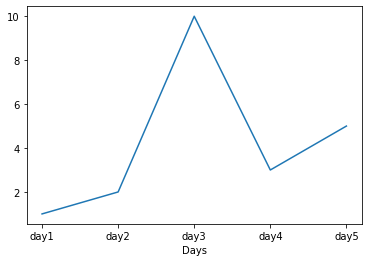

In [24]:
import matplotlib.pyplot as plt

list = [1,2,10,3,5]
days = ["day1", "day2", "day3", "day4", "day5"] # loop through like ukraine tweets file name to populate

plt.plot(days, list)
plt.xlabel("Days")
plt.ylabel("")
plt.show()


In [80]:
p = str(Path.cwd()) + "/NewGSData"
files = sorted(glob.glob(os.path.join(p,"*")))

# for f in files:
#     print(os.path.basename(f).split('/')[0])


Days = []

for f in files:
    # print(os.path.basename(f).split('/')[0])
    gsnd = os.path.basename(f).split('/')[-1][2:]
    print(gsnd)
    Days.append(gsnd)



2022-02-22
2022-02-23
2022-02-24
2022-02-25
2022-02-26
2022-02-27
2022-02-28
2022-03-01
2022-03-02
2022-03-03
2022-03-04
2022-03-05
2022-03-06
2022-03-07
2022-03-08
2022-03-09
2022-03-10
2022-03-11
2022-03-12
2022-03-13
2022-03-14
2022-03-15
2022-03-16
2022-03-17
2022-03-18
2022-03-19
2022-03-20
2022-03-21
2022-03-22
2022-03-23
2022-03-24
2022-03-25
2022-03-26
2022-03-27
2022-03-28
2022-03-29
2022-03-30
2022-03-31
2022-04-01
2022-04-02
2022-04-03
2022-04-04
2022-04-05
2022-04-06
2022-04-07
2022-04-08
2022-04-09
2022-04-10
2022-04-11
2022-04-12
2022-04-13
2022-04-14
2022-04-15
2022-04-16
2022-04-17
2022-04-18
2022-04-19
2022-04-20
2022-04-21
2022-04-22
2022-04-23
2022-04-24
2022-04-25
2022-04-26
2022-04-27
2022-04-28
2022-04-29
2022-04-30
2022-05-01
2022-05-02
2022-05-03
2022-05-04
2022-05-05
2022-05-06
2022-05-07
2022-05-08
2022-05-09
2022-05-10
2022-05-11
2022-05-12
2022-05-13
2022-05-14
2022-05-15
2022-05-16
2022-05-17
2022-05-18
2022-05-19
2022-05-20
2022-05-21
2022-05-22
2022-05-23

In [128]:
words = ['needs']
y = []
for f in files:
    count = 0
    df2 = pd.read_csv(f,encoding='utf-8')
    df2 = df2.drop_duplicates(subset="text")
    size = 1
    size = len(df2)
    count = df2["text"].str.contains("gun", case = False).sum()
    print(count)
    y.append(count/size)

print(len(Days))
print(len(y))

2
10
5
6
6
6
3
6
6
7
4
1
2
3
7
2
4
5
6
6
8
4
5
2
2
3
3
1
4
2
6
5
1
6
9
5
3
3
3
5
6
4
2
1
2
1
2
3
8
11
5
5
4
1
3
3
8
6
3
0
1
4
0
9
4
4
3
2
1
1
2
1
1
1
1
6
4
5
3
4
2
2
8
5
3
2
4
3
2
1
6
4
35
23
21
16
13
16
11
14
14
22
10
8
6
9
12
6
6
1
9
2
6
5
2
7
6
3
4
5
5
6
2
1
1
2
4
4
3
4
3
10
4
4
1
3
2
1
1
2
1
1
1
0
1
1
2
0
3
4
1
1
2
2
2
2
1
2
6
1
1
4
3
2
2
2
0
3
3
3
1
1
1
0
1
0
1
2
0
0
2
0
2
2
1
3
3
2
0
2
3
1
1
1
1
2
0
2
4
1
0
3
1
1
0
1
1
1
2
0
3
4
3
4
6
3
5
3
8
4
2
3
222
222


In [115]:
unlabeledDays = []

for i in range(222):
    unlabeledDays.append(i)

print(len(unlabeledDays))

222


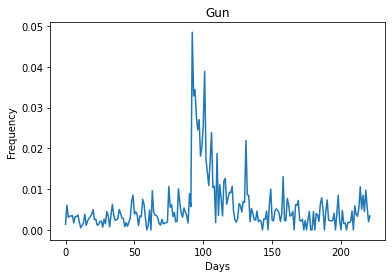

In [129]:
# Needs
plt.plot(unlabeledDays, y)
plt.xlabel("Days")
plt.ylabel("Frequency")
# plt.xlim([0,200])
plt.title("Gun")
plt.show()